HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [1]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions

## Load and Preprocess the data

In [2]:
ddir = "../data/mouse_df.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [18]:
# Group by animal name and count trials
trial_counts = combine(groupby(df, :name), nrow => :trial_count)

# Sort by count in descending order
sort!(trial_counts, :trial_count, rev=true)

# pick a mouse of interest (start with mouse of most trials)
moi = trial_counts[1, :name]

# get the data for the mouse of interest
mouse_df = df[df.name .== moi, :]

# get the RT and correct/incorrect chocies for said mouse. Map correct -> 1 and incorrect -> -1
outcomes = df[df.name .== moi, :outcome]
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in mouse_df.outcome]

# now RTs 
rts = df[df.name .== moi, :rt]

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in mouse_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Extract RTs and outcomes for this date
    day_rts = rts[day_indices]
    day_outcomes = numeric_outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

12311-element Vector{DDMResult}:
 DDMResult(0.2716, 1)
 DDMResult(0.4124, -1)
 DDMResult(0.2669, 1)
 DDMResult(0.8428, 1)
 DDMResult(0.3541, 1)
 DDMResult(0.247, 1)
 DDMResult(0.4099, 1)
 DDMResult(0.2372, -1)
 DDMResult(0.3275, -1)
 DDMResult(0.2344, 1)
 ⋮
 DDMResult(0.4864, 1)
 DDMResult(0.2847, -1)
 DDMResult(0.2424, 1)
 DDMResult(0.4899, -1)
 DDMResult(0.226, -1)
 DDMResult(0.2562, -1)
 DDMResult(0.5747, 1)
 DDMResult(0.3208, 1)
 DDMResult(0.4196, 1)

## Perform Cross Validation

For these CV procedure we will do the following procedure:

- Shuffle the data across sessions
- Split the data into 5 folds
- For each numbert of states K in [2, 3, 4, 5]
    - For each fold
        - For 10 itemouseions
            - Randomly initialize the model parameters
            - Fit the model to the training data
            - Evaluate the model on the test data
            - Store the model parameters and performance metrics
        - Store the best model parameters and performance metrics
        - Compute the mean and standard deviation of the performance metrics across itemouseions

- Refit the best model of the selected K states to the entire dataset

In [4]:
cv_results, nobs = crossvalidate(results_by_date; n_states=2, n_folds=3, n_iter=3)

┌ Info: ⇢ evaluating 1 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:51
┌ Info: ⇢ evaluating 2 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:51


(ll = Dict(2 => [-3150.098688931106 -2486.9065661470645 -2260.862196797379; -2225.278732170556 -1740.1264212675214 -1604.2147077995915; -2225.276299104812 -1740.1213237424174 -2312.4109175732087], 1 => [-3159.8258747170303 -2737.4876508560783 -2322.1442448068233; -3159.8258747174314 -2737.487650856117 -2322.1442448067774; -3159.825874717865 -2737.487650855467 -2322.144244806651]), nobs = [8940 10037 7920; 8940 10037 7920; 8940 10037 7920])

In [ ]:
function calculate_ll_mouseio(ℓℓ::Float64, ℓℓ₀::Float64, n::Int)
    ll_mouseio = ℓℓ - ℓℓ₀
    return ll_mouseio / (n * log(2))
end

calculate_ll_ratio (generic function with 1 method)

In [13]:
mean(calculate_ll_ratio.( cv_results[2], cv_results[1], nobs ), dims=1)

1×3 Matrix{Float64}:
 0.101065  0.107578  0.0479043

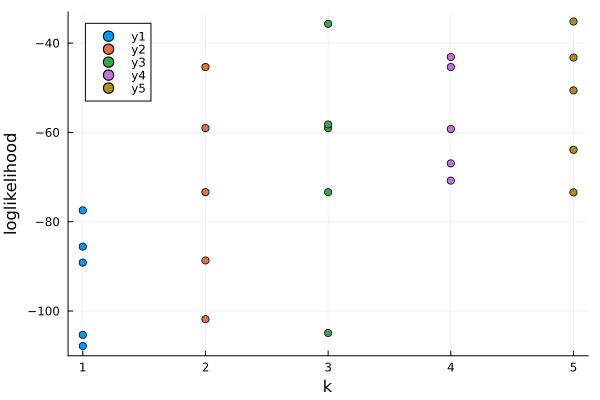

In [20]:
plot(xlabel="k", ylabel="loglikelihood")
for i in 1:5
    scatter!([i for _ in 1:5], cv_results[i])
end
display(current())

In [19]:
# generate a HMM to start from
trans_guess = [0.5 0.5; 0.5 0.5]
init_guess = [0.99, 0.01]

ddm_1_guess = DriftDiffusionModel(10, 1, 0, 1)
ddm_2_guess = DriftDiffusionModel(1, 0.1, 0, 1)

dists_guess = [ddm_1_guess, ddm_2_guess]

hmm = PriorHMM(init_guess, trans_guess, dists_guess, 2., 2.)

hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(PriorHMM{Float64, DriftDiffusionModel}([0.2522107914165648, 0.7477892085834352], [0.4593675986213085 0.5406324013786915; 0.26482231014900104 0.735177689850999], DriftDiffusionModel[DriftDiffusionModel(1.3335961991119958, 2.1215348580676836, -0.12945484273775162, 1.0), DriftDiffusionModel(2.545469767327298, 8.433104915452661, -0.04780331974248398, 1.0)], 2.0, 2.0), [-18399.30517675912, 5222.221039922242, 5539.769920642376, 5689.858097964584, 5800.047371994124, 5894.119834538778, 5974.930609990295, 6049.767976088603, 6120.062094273323, 6187.107973286257  …  6884.121250561197, 6884.121485439754, 6884.121661776535, 6884.121792505417, 6884.121887844612, 6884.12195585297, 6884.1220028738, 6884.122033888793, 6884.122052800084, 6884.122062654946])

In [21]:
hmm_est

PriorHMM{Float64, DriftDiffusionModel}([0.2522107914165648, 0.7477892085834352], [0.4593675986213085 0.5406324013786915; 0.26482231014900104 0.735177689850999], DriftDiffusionModel[DriftDiffusionModel(1.3335961991119958, 2.1215348580676836, -0.12945484273775162, 1.0), DriftDiffusionModel(2.545469767327298, 8.433104915452661, -0.04780331974248398, 1.0)], 2.0, 2.0)

## Confirm the LL converges!

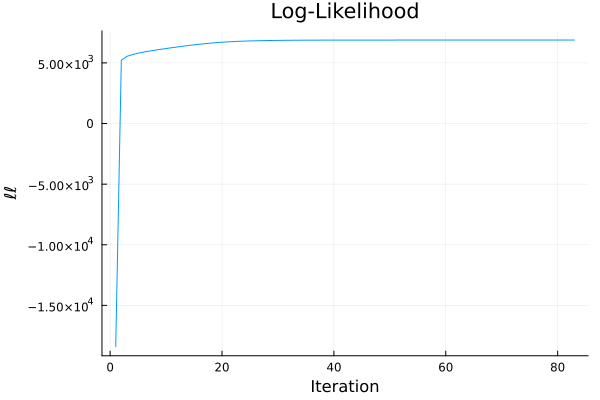

In [20]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


In [12]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

2×3547 Matrix{Float64}:
 0.13339  0.307454  0.0770967  0.0396896  …  1.0         0.345611  0.197875
 0.86661  0.692546  0.922903   0.96031       1.41928e-7  0.654389  0.802125

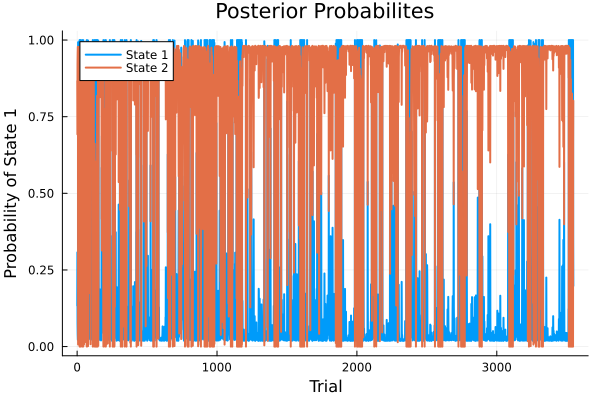

In [14]:
plot(γ[1, :], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State 1", label="State 1", linewidth=2)
plot!(γ[2, :], label="State 2", linewidth=2)